In [1]:
import copy
import glob
import pickle
import warnings
from datetime import datetime, timedelta
from itertools import product
import joblib
import os

import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.feature as cf
import cartopy.io.shapereader as shpreader
import matplotlib as mpl
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
# np.random.seed(42)
import pandas as pd
import shapely.geometry as sgeom
import xarray as xr
from scipy import stats
from scipy.spatial.distance import cdist
from shapely import geometry
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# import cluster_analysis, narm_analysis, som_analysis

# Load data

## Weather regimes

In [2]:
week1_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week1_wr_v3.csv',\
                      index_col = 0, parse_dates = True)
week2_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week2_wr_v3.csv',\
                      index_col = 0, parse_dates = True)
week3_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week3_wr_v3.csv',\
                      index_col = 0, parse_dates = True)
week4_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week4_wr_v3.csv',\
                      index_col = 0, parse_dates = True)
week5_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week5_wr_v3.csv',\
                      index_col = 0, parse_dates = True)
week6_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week6_wr_v3.csv',\
                      index_col = 0, parse_dates = True)
week7_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week7_wr_v3.csv',\
                      index_col = 0, parse_dates = True)
week8_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week8_wr_v3.csv',\
                      index_col = 0, parse_dates = True)
week9_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week9_wr_v3.csv',\
                      index_col = 0, parse_dates = True)

df_wr = pd.concat([week1_wr,week2_wr,week3_wr,week4_wr,week5_wr,week6_wr,week7_wr,week8_wr,week9_wr],axis=1)
df_wr.columns = ['week1','week2','week3','week4','week5','week6','week7','week8','week9']

df_wr_2 = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/weekly_wr_mean_geop_v3.csv',
                     index_col=0,parse_dates=True)

df_wr_2 = df_wr_2.dropna()
df_wr = df_wr.dropna()

## Input Variables

In [3]:
variables = ['z500','olr', 'sst', 'u10', 'sm_region', 'st_region']
name_var = ['z500','olr', 'sst', 'u10', 'sm', 'st']
units = ['m2/s2','J/m2','K','m/s','m3/m3','K']


In [4]:
dic_vars = {}
for var_short, variable,unit in zip(name_var,variables,units):
# for var_short, variable,unit in zip(['sst'],['sst'],['K']):
    path_w_anoms = '/glade/work/jhayron/Weather_Regimes/weekly_anomalies/'
    week1_anoms = xr.open_dataset(f'{path_w_anoms}week1_{variable}_anoms_v3.nc')
    # week1_anoms = week1_anoms.sel(time=df_wr_2.index)
    if variable=='z500':
        week1_anoms = week1_anoms.where(week1_anoms.lat>-30,drop=True)
    # week1_anoms = week1_anoms.sel(time=df_wr.index)
    week1_anoms = week1_anoms.sel(time=df_wr_2.index)
    dic_vars[variable] = week1_anoms
    
    ##########PLOT#####################
#     fig = plt.figure(figsize=(9,7))
#     ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=-90+360))
    
#     #     vmax = np.round(np.percentile(abs(week1_anoms[f'{var_short}_anomalies'].values[0]),100),0)
#     #     vmin = -np.round(np.percentile(abs(week1_anoms[f'{var_short}_anomalies'].values[0]),100),0)
    
#     vmax = np.round(np.percentile(abs(week1_anoms[f'{var_short}_anomalies'].values[0]),100),0)
#     vmin = -np.round(np.percentile(abs(week1_anoms[f'{var_short}_anomalies'].values[0]),100),0)
#     # print(vmax,vmin)
#     cs = plt.pcolormesh(week1_anoms.lon,week1_anoms.lat,\
#         week1_anoms[f'{var_short}_anomalies'].values[0],cmap='seismic',
#         transform=ccrs.PlateCarree(),vmin=vmin,vmax=vmax)
#     ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
#     ax.margins(x=0, y=0)

#     # ax.set_extent([-179, 179, 10, 90], crs=ccrs.PlateCarree())
#     if variable!='st':
#         plt.title(variable.upper().replace('_','-'))
#     else:
#         plt.title(variable.upper().replace('_','-').replace('ST','TS'))
#     if 'region' in variable:
#         cbar_ax = fig.add_axes([0.25, 0.19, 0.5, 0.0175])
#     else:
#         cbar_ax = fig.add_axes([0.25, 0.3, 0.5, 0.0175])
#     # ticks_1 = [-80, -40, 0, 40, 80]
#     cbar = fig.colorbar(cs, cax=cbar_ax,
#                         orientation='horizontal', extend='both')
#     cbar.ax.tick_params(labelsize=14)
#     cbar.set_label(unit, fontsize=14)
#     plt.savefig(f'/glade/u/home/jhayron/WeatherRegimes/Figures/MapsVariables/{variable}_anomalies_v2.png',bbox_inches='tight')
#     plt.close('all')

# Build models

In [5]:
import keras
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, AveragePooling2D
from keras.utils import to_categorical
from keras.layers import LeakyReLU
from keras.layers import ReLU
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
# import visualkeras
# import tensorflow as tf

# ## GLOBAL SEED ##    
# np.random.seed(42)
# tf.random.set_seed(42)

# Train

In [6]:
def create_model(activation_conv = ReLU()):
    num_classes = 4
    # alpha=0.01
    ks = 3
    ps = 5
    nfilters=64
    padding_type = 'valid'
    model = Sequential()
    model.add(Conv2D(nfilters, kernel_size=(ks, ks),activation=activation_conv,
        input_shape=X_train.shape[1:],padding=padding_type))
    model.add(AveragePooling2D((ps, ps),padding=padding_type))
    
    model.add(Conv2D(nfilters*2, (ks, ks), activation=activation_conv,padding=padding_type))
    model.add(AveragePooling2D(pool_size=(ps, ps),padding=padding_type))
    
    # model.add(Conv2D(nfilters*3, (ks, ks), activation=activation_conv,padding=padding_type))
    # model.add(AveragePooling2D(pool_size=(ps, ps),padding=padding_type))
    
    # model.add(Conv2D(128, (ks, ks), activation=activation_conv,padding='same'))
    # model.add(AveragePooling2D(pool_size=(ks, ks),padding='same'))
    
    model.add(Flatten())
    model.add(Dense(128, activation=activation_conv))
    model.add(Dense(64, activation=activation_conv))
    model.add(Dense(64, activation=activation_conv))
    # model.add(Dense(nfilters, activation=activation_conv))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy, 
        optimizer=keras.optimizers.Adam(lr=0.0001),metrics=['accuracy'])
    return model



In [7]:
path_models = '/glade/work/jhayron/Weather_Regimes/models/CNN/weights_variables_v3/'

In [8]:
dic_metrics = {}

for var_short, variable in zip(name_var,variables):
    print('********************************************************************************************')
    print(variable)
    print('********************************************************************************************')
    loss_weeks_model = []
    loss_weeks_persistence = []
    acc_weeks_model = []
    acc_weeks_persistence = []

    for week in ['week2','week3','week4','week5','week6','week7','week8','week9']:
        print(week)
        #### ORGANIZE DATA ####
        week_output_wr = df_wr_2[week].values.astype(int)
        # Make Y categorical
        serie_wr_categorical = to_categorical(week_output_wr,num_classes=4)
        
        week1_anoms = copy.deepcopy(dic_vars[variable])
        
        # # Scale by min-max
        where = np.where(pd.to_datetime(week1_anoms.time.values).year<=2010)[0]
        Min = week1_anoms.isel(time=where)[f'{var_short}_anomalies'].min(dim='time')
        Max = week1_anoms.isel(time=where)[f'{var_short}_anomalies'].max(dim='time')
        scaled_x = (week1_anoms[f'{var_short}_anomalies']) / (Max - Min)

        indices = np.arange(len(serie_wr_categorical))
        #Reshape X
        scaled_x = scaled_x.data.reshape(-1, scaled_x.shape[1],scaled_x.shape[2], 1)
        scaled_x[np.isfinite(scaled_x)==False]=0
        
        indices_train = np.where(df_wr_2.week2.index.year<=2001)[0]
        indices_val = np.where((df_wr_2.week2.index.year>2001)&(df_wr_2.week2.index.year<=2010))[0]
        indices_test = np.where(df_wr_2.week2.index.year>2010)[0]

        X_test = scaled_x[indices_test]
        y_test = serie_wr_categorical[indices_test]

        X_train = scaled_x[indices_train]
        y_train = serie_wr_categorical[indices_train]

        X_val = scaled_x[indices_val]
        y_val = serie_wr_categorical[indices_val]

        wr_persistence = df_wr_2.week1.values.astype(int)[indices_test]
        serie_wr_persistence_categorical = to_categorical(wr_persistence)

        #### TRAIN ####

        keras.backend.clear_session()
        model = create_model()
        batch_size = 16
        epochs = 200

        earlystop = EarlyStopping(monitor='val_loss', patience=5)
        try:
            os.mkdir(f'{path_models}{variable}')
        except: pass
        filepath = f'{path_models}{variable}/model_{week}_v3.h5'
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, 
                                     mode='auto',save_weights_only=False)
        model.fit(X_train, y_train, batch_size=batch_size,\
            epochs=epochs,verbose=0,validation_data=(X_val, y_val), callbacks=[checkpoint,earlystop])

        #### EVAL ####

        model.load_weights(filepath)
        # model.save(filepath) WHAT IS THIS
        metrics_model = model.evaluate(x=X_test,y=y_test)
        acc_temp = metrics_model[1]
        loss_temp = metrics_model[0]
        acc_persistence = accuracy_score(y_test,serie_wr_persistence_categorical)
        loss_persistence = log_loss(y_test,serie_wr_persistence_categorical)
        print('loss/acc model')
        print(metrics_model)
        print('loss/acc persistence')
        print([loss_persistence,acc_persistence])

        loss_weeks_model.append(loss_temp)
        loss_weeks_persistence.append(loss_persistence)
        acc_weeks_model.append(acc_temp)
        acc_weeks_persistence.append(acc_persistence)
        
    ### PLOT BARS ###
    plt.bar(np.arange(8),acc_weeks_model,width=-0.3,align='edge',label=f'CNN - {variable.upper()}',color='k')
    plt.bar(np.arange(8),acc_weeks_persistence,width=0.3,align='edge',label='Persistence',color='darkorange')
    plt.legend()
    plt.ylabel('Percentage of accurate predictions [%]\nTesting Sample (15%)')
    plt.xticks(np.arange(8),['Week 1','Week 2','Week 3','Week 4','Week 5','Week 6','Week 7','Week 8'])
    plt.xlabel('Lead time')
    path_figures = '/glade/u/home/jhayron/WeatherRegimes/Figures/Variables/'
    plt.savefig(f'{path_figures}{variable}_SvP_v2.png',bbox_inches='tight')
    plt.close('all')
    
    ### SAVE METRICS ###
    
    df_metrics = pd.DataFrame(np.array([acc_weeks_model,acc_weeks_persistence,loss_weeks_model,loss_weeks_persistence]).T,
            columns = ['acc_model','acc_persistence','loss_model','loss_persistence'])
    dic_metrics[variable] = df_metrics
    

********************************************************************************************
z500
********************************************************************************************
week2
18/18 [==============================] - 0s 9ms/step - loss: 1.2684 - accuracy: 0.4396
loss/acc model
[1.2684290409088135, 0.4396396279335022]
loss/acc persistence
[19.78978539544183, 0.42702702702702705]
week3
18/18 [==============================] - 0s 9ms/step - loss: 1.3773 - accuracy: 0.3243
loss/acc model
[1.3772944211959839, 0.3243243098258972]
loss/acc persistence
[25.701828202256213, 0.25585585585585585]
week4
18/18 [==============================] - 0s 8ms/step - loss: 1.3657 - accuracy: 0.2865
loss/acc model
[1.3656611442565918, 0.2864864766597748]
loss/acc persistence
[25.26620399543831, 0.26846846846846845]
week5
18/18 [==============================] - 0s 7ms/step - loss: 1.3885 - accuracy: 0.3117
loss/acc model
[1.3885000944137573, 0.31171169877052307]
loss/acc persistence
[24.

In [9]:
len(indices_train)

2240

In [10]:
len(indices_val)

468

In [11]:
len(indices_test)

555

In [12]:
colors = ['royalblue','blueviolet','red','gold','limegreen','coral']


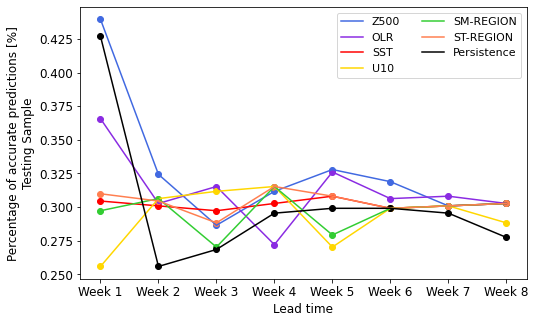

In [13]:
plt.figure(figsize=(8,5))
for i in range(len(variables)):
    plt.plot(np.arange(8),dic_metrics[variables[i]].acc_model, color=colors[i],
             label=variables[i].upper().replace('_','-'))
    plt.scatter(np.arange(8),dic_metrics[variables[i]].acc_model,color=colors[i])
plt.plot(np.arange(8),dic_metrics[variable].acc_persistence,label='Persistence',color='k')
plt.scatter(np.arange(8),dic_metrics[variable].acc_persistence,color='k')
plt.legend(ncol=2,fontsize=11)
plt.ylabel('Percentage of accurate predictions [%]\nTesting Sample',fontsize=12)
plt.xticks(np.arange(8),['Week 1','Week 2','Week 3','Week 4','Week 5','Week 6','Week 7','Week 8'],fontsize=12)
plt.xlabel('Lead time',fontsize=12)
plt.yticks(fontsize=12)
path_figures = '/glade/u/home/jhayron/WeatherRegimes/Figures/'
plt.savefig(f'{path_figures}Accuracy_CNN_Variables_v3.png',bbox_inches='tight')

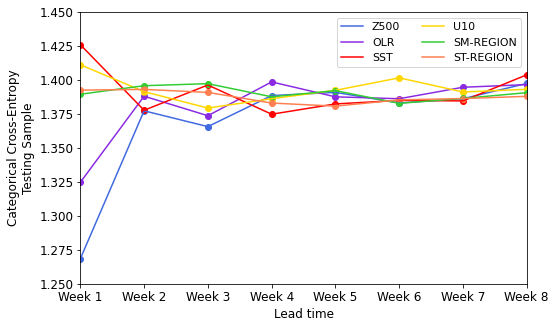

In [17]:
plt.figure(figsize=(8,5))
for i in range(len(variables)):
    plt.plot(np.arange(8),dic_metrics[variables[i]].loss_model, color=colors[i],
             label=variables[i].upper().replace('_','-'))
    plt.scatter(np.arange(8),dic_metrics[variables[i]].loss_model,color=colors[i])
# plt.plot(np.arange(8),dic_metrics[variable].loss_persistence,label='Persistence',color='k')
# plt.scatter(np.arange(8),dic_metrics[variable].loss_persistence,color='k')
plt.legend(ncol=2,fontsize=11)
plt.ylabel('Categorical Cross-Entropy\nTesting Sample',fontsize=12)
plt.xticks(np.arange(8),['Week 1','Week 2','Week 3','Week 4','Week 5','Week 6','Week 7','Week 8'],fontsize=12)
plt.xlabel('Lead time',fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(1.25,1.45)
plt.xlim(0,7)
path_figures = '/glade/u/home/jhayron/WeatherRegimes/Figures/'
plt.savefig(f'{path_figures}Loss_CNN_Variables_v3.png',bbox_inches='tight')


In [18]:
np.save('/glade/work/jhayron/Weather_Regimes/models/CNN/metrics/dic_metrics_v3',dic_metrics)